# AI in Industry project
# Flare prediction
- Ildebrando Simeoni - ildebrando.simeoni@studio.unibo.it
- Davide Femia - davide.femia@studio.unibo.it
- Riccardo Falco - riccardo.falco2@tudio.unibo.it
- Vincenzo Collura - vincenzo.collura2@studio.unibo.it


## The problem

### Mathematical background

A stochastic differential equation (SDE) is a differential equation in which one or more of the terms is a stochastic process, resulting in a solution which is also a stochastic process. SDEs are used to model various phenomena such as stock prices or physical systems subject to thermal fluctuations. Typically, SDEs contain a variable which represents random white noise calculated as the derivative of Brownian motion or the Wiener process.

A typical SDE has the form


$$ dXt = a(Xt, t) dt + b(Xt, t) dWt \hspace{2cm}(1)$$

Where the coefficients are $a(x, t)$, which is the drift coefficient, and $b(x, t)$, which is the noise coefficient.

### Our problem

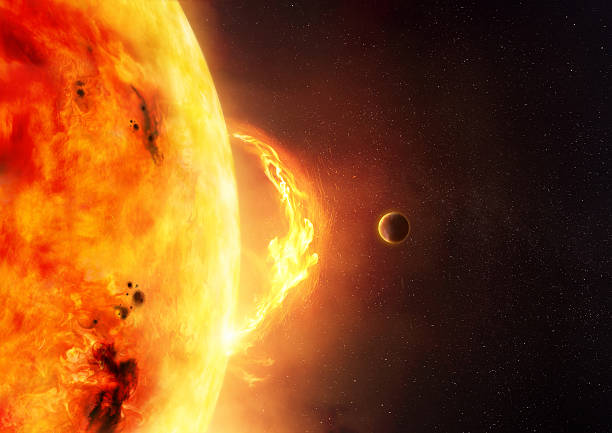

The model, derived from Tavecchio et al. 2020 [\[1\]](https://arxiv.org/pdf/2004.09149.pdf) assumes the following stochastic differential equation (SDE):

$$ dX = \theta (\mu − X)d_t + \sigma XdW_t \hspace{2cm}  (2)$$

specified by the parameters $\theta$ (the inverse of the time scale of the drift term), $\mu$ (equilibrium
value for 𝑋) and $\sigma$ (coefficient of the stochastic term).

Eq. (0.1) describes a quite simple underlying dynamics: the deterministic (drift) term pushes
the system toward an equilibrium value $\mu$, while the evolution is disturbed by a random noise
whose amplitude is proportional to the actual value of 𝑋. Hence, high states, characterized
by large 𝑋, will also display the largest fluctuations.
SDE are commonly solved by using standard numerical schemes. 

For the specific SDE we are considering, the [Milstein method](https://en.wikipedia.org/wiki/Milstein_method) is appropriate. Applying this method we obtain the following:
$$ X_{i+1} = X_i + \theta(1 − x_i)\Delta t +\sigma W_iX_i \sqrt{\Delta t}+\frac{1}{2}\sigma^2 X_i \Delta t (W^2_i-1) \hspace{2cm} (3)$$
<!-- 
𝑋𝑖+1 = 𝑋𝑖 + 𝜃(1 − 𝑥𝑖)Δ𝑡 + 𝜎𝑊𝑖𝑋𝑖
√
Δ𝑡 +
1
2
𝜎2𝑋𝑖Δ𝑡(𝑊2
𝑖 − 1) (0.2) 
-->

where $W_i$ is a random variable chosen from a normal distribution with mean 0 and standard deviation 1, i.e. $W_i \sim N(0,1)$.

## Libraries

In [1]:
%load_ext autoreload
%autoreload 2
from Libs.load_data import DataLoader
from Libs import flares_plot as fplt
from Libs.threshold import get_labels_physic, get_labels_KDE, get_labels_quantile, get_labels_quantile_on_run
from Libs.config import inspection_data_folder
import numpy as np
import pandas as pd

## Data generation

We generated a large synthetic dataset, including not only the "standard" parameter configurations 
provided in the paper, but also by varying these, resulting in a grid of $30 \text{ x } 4 \text{ x } 4 \text{ x } 4 \text{ x } 10 \text{ x } 1000$ samples

In [2]:
# initialize data loader
override = False
data_loader = DataLoader(run=30, N=1000, override=override, folder=inspection_data_folder, labelling_method=None, 
                         s=[0.3,0.4,0.5,0.6], 
                         t=[0.01,0.1,0.5,3], 
                         m=[0.8,0.9,1,1.1],
                         d=[0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7])
# get the grid
grid = data_loader.get_grid()
# get params dictionary
params = data_loader.get_params()
print('Parameters that can change values:')
params

Parameters that can change values:


{'run': 30,
 'sigma': [0.3, 0.4, 0.5, 0.6],
 'theta': [0.01, 0.1, 0.5, 3],
 'mu': [0.8, 0.9, 1, 1.1],
 'delta': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
 'N': 1000}

## Data inspection
<!-- In the following paragraph the data generated are carefully inspected, in particular the following informations are shown:


*   a comparison between the histogram and the Tavecchio et al. pdf from the paper 
*   estimate of the distribution of $P(X_{t+1}|X_t)$ given a certain configuration of parameter by a bidimensional histogram (we group values in equal spaced bins and count the values that enter within each bin)
*   histograms of data by changing one parameter at a time and leaving the others unchanged 
*   examples of time series as individual parameters change -->

Tavecchio et al. [\[1\]](https://arxiv.org/pdf/2004.09149.pdf) defines the steady state pdf as the following:
$$ k\frac{e^{-\lambda\mu / X}}{X^{\lambda +2}}  \hspace{2cm}  (4)$$ 

with $\lambda=2\frac{\theta}{\sigma^2}$ and $k$ is determined by the normalization condition: 
$$\int_{0}^{\infty} \ dX \ p(X) \space = 1 $$

Below the comparison between the actual pdf defined in the paper and the histograms of light values obtained from the synthetic data generated before at different parameters configurations are shown

First configuration: $\mu=1, \sigma=0.5, \theta=3, \delta_t=0.2$

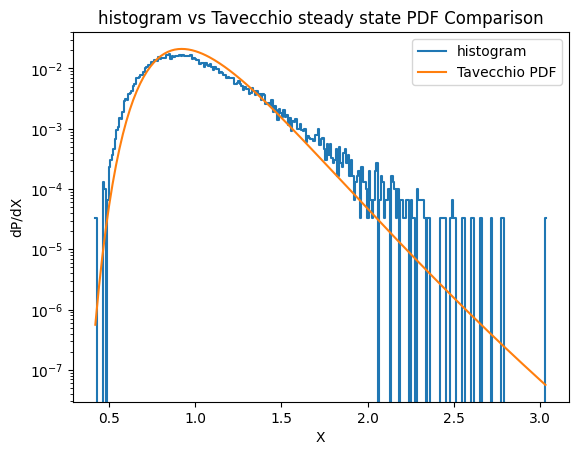

In [3]:
run, mu, sigma, theta, delta = 0, 1, 0.5, 3, 0.2
title = 'histogram vs Tavecchio steady state PDF Comparison'
fplt.plot_grid_PDF(grid, params, nbins=300, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, 
                   on_run=False, dstep=1e-2, title=title)

Second configuration: $\mu=1, \sigma=0.5, \theta=0.1, \delta_t=0.2$ 


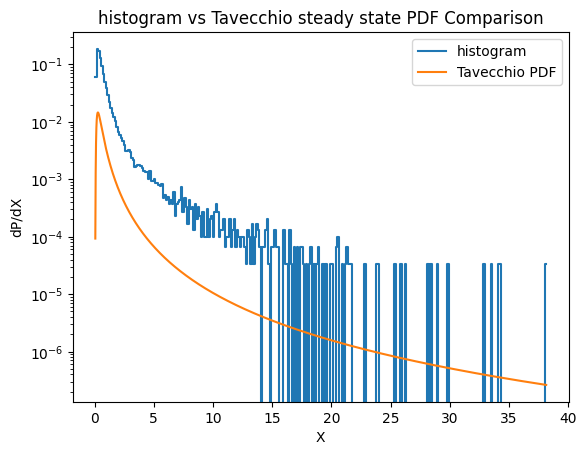

In [4]:
run, mu, sigma, theta, delta = 0, 1, 0.5, 0.1, 0.2
title = 'histogram vs Tavecchio steady state PDF Comparison'
fplt.plot_grid_PDF(grid, params, nbins=300, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, 
                   on_run=False, dstep=1e-2, title=title)

Both results are similar and resemble the actual pdf.

Moreover, both histograms have a tail, composed of boxes having the same height, much larger than the actual pdf.
This is due to the fact that we have "only" 30 runs and 1000 time measures of light, therefore if a light value appears only once we get a minimum value of $1/30.000=3*10^{-5}$ after the normalization, so few high light values due to the stochasticity of the problem result in the last tail.

The preeceding ones are good sanity check which makes us guess that our implementaion and solution of the SDE is correct and coherent with the specifications highlighted in the paper.

Here an estimate of the distribution of $P(X_{t+1}|X_t)$ given a certain configuration of parameter ($\mu=1, \sigma=0.5, \theta=3, \delta_t=0.2$) by a bidimensional histogram (we group values in equal spaced bins and count the values that enter within each bin) is shown.

What we observe is what we expected, namely that following values are most of the time similar in intensity (i.e. they are mostly spread over the diagonal of the histogram) and are usually clustered around the value of $\mu$ (i.e. the equilibrium value for 𝑋)

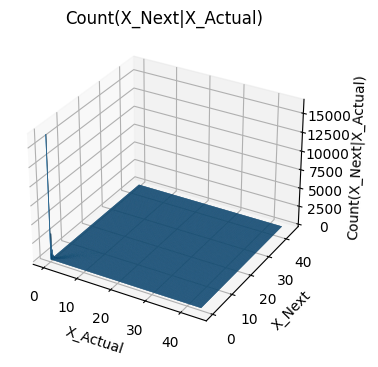

In [5]:
run, mu, sigma, theta, delta = 0, 1, 0.5, 0.01, 0.2
normalize=False
if normalize:
    title = 'P(X_Next|X_Actual)'
else:
    title = 'Count(X_Next|X_Actual)'
fplt.histogram_next_given_actual(grid, params, nbins=300, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, 
                                 on_run=False, normalize=normalize, title=title)

Now we are going to explore the role of each parameter in the differential equation, in order to understand better the data behaviour

### Varying $\mu$
* This is the __equilibrium value__ for $X$, the light curve time values
* Acording to the paper, the largest peaks are separated by long period of quiescent level in which $X$ values fluctuates around $\mu$.
* By the way, no particular differences seems to emerge from the plot varying this parameter, except for small changes in the steady state of the light curve values.
    * This could be due to the small distances in different values of the aforementioned parameter

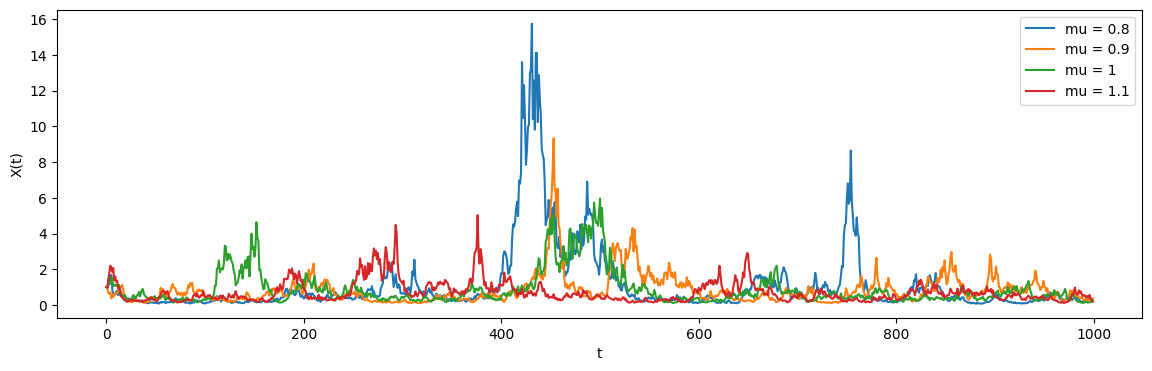

In [6]:
run, sigma, theta, delta = 2, 0.5, 0.1, 0.2
fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, variation='mu')

Similarly, no great differences in histograms comparing different time series generated with different values of mu. In the plot we find in the x axis light values bins and in y axis the normalized counts of each bin. 

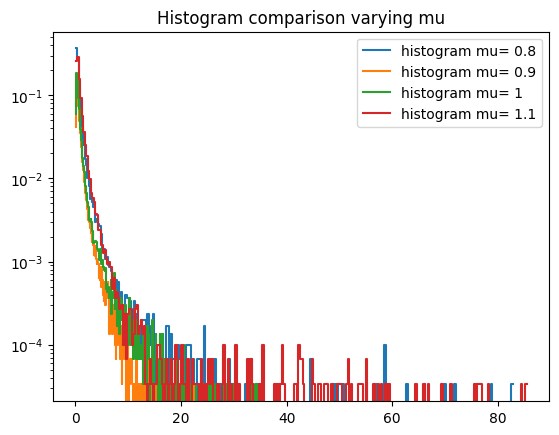

(0.06182085226214582, 85.44997391974495)

In [7]:
title = 'Histogram comparison varying mu'
fplt.plot_histograms(grid, params, nbins=300, sigma=sigma, mu=mu, delta=delta, 
                     variation='mu', on_run=False, title=title)

### Varying $\theta$

* The parameter $1/\theta$ quantifies the timescale associated to the __drift term.__
    * The parameter $\theta$ is thus the __inverse of the time scale of the drift term__
* The synthetic light curves never settles into real steady states,$X(t)$ rather describes a fluctuating evolution with episodic flares whose amplitude is larger for smaller values of $\theta$. On the other hand, higher values of $\theta$ increase the effect of the deterministic term, allowing the time series to remain more clustered around the equilibrium value.

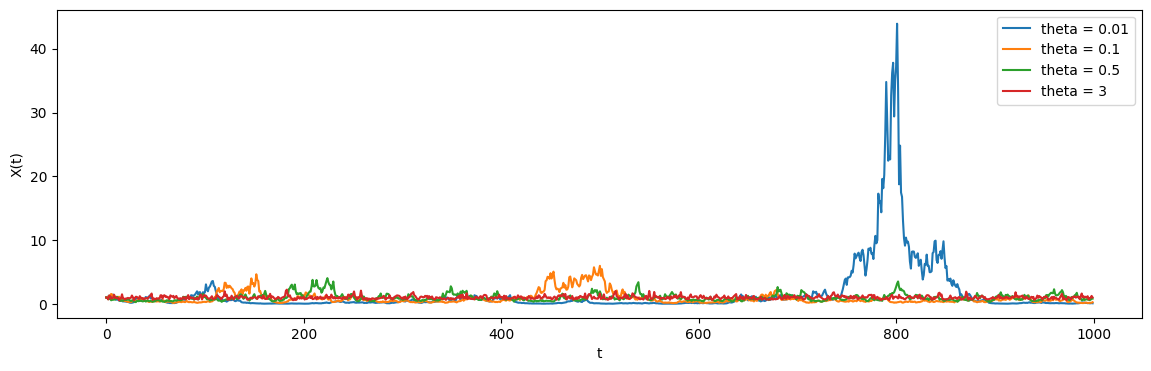

In [8]:
run, mu, sigma, delta = 2, 1, 0.5, 0.2
fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, variation='theta')

Here we check the values distribution varying the $\theta$ parameter, by estimating them with some histograms. 

We can immediately notice the similarity with our estimation and what done by Tavecchio et al [\[1\]](https://arxiv.org/pdf/2004.09149.pdf), by looking at the following plot and the one in next cell:

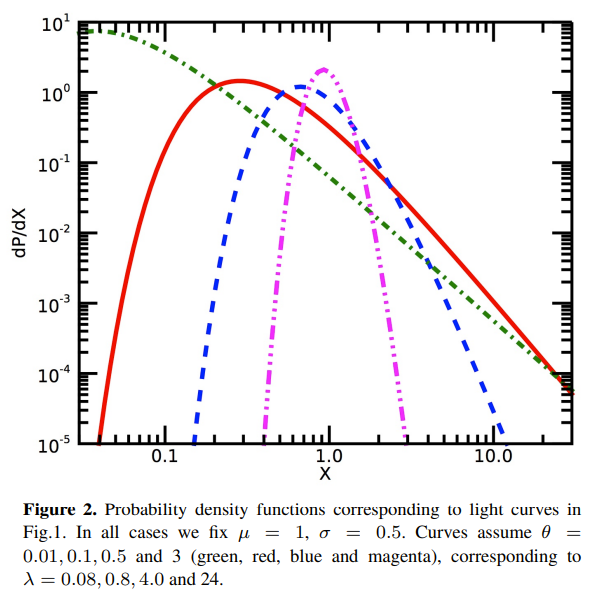

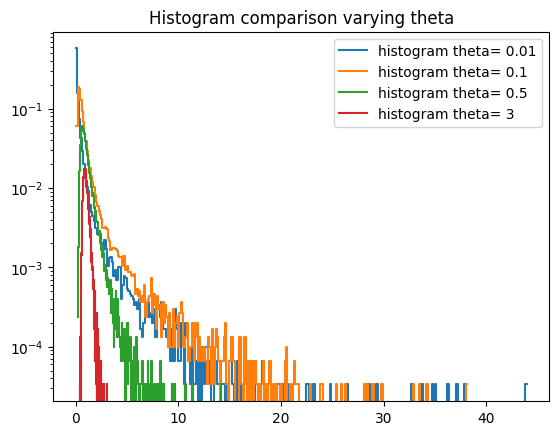

(0.00890338388671107, 43.91814194922223)

In [9]:
title = 'Histogram comparison varying theta'
fplt.plot_histograms(grid, params, nbins=300, sigma=sigma, mu=mu, delta=delta, 
                     variation='theta', on_run=False, title=title)

### Varying $\sigma$

* This is the __coefficient of the stochastic term__.
    * This parameter measures the strength of the stochastic perturbation to the system 
* It's related to the dynamics of the amplification/dissipation processes. As expected, an higher number of peaks/fluctuations is observed increasing the value of sigma.

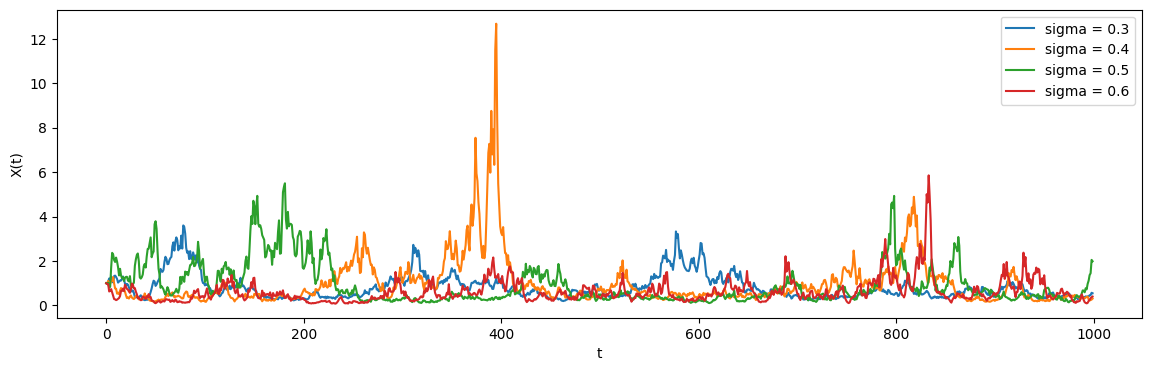

In [10]:
run, mu, theta, delta = 0, 1, 0.1, 0.2
fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, variation='sigma')

Finally we show also histogram varying the value for $\sigma$ parameter.

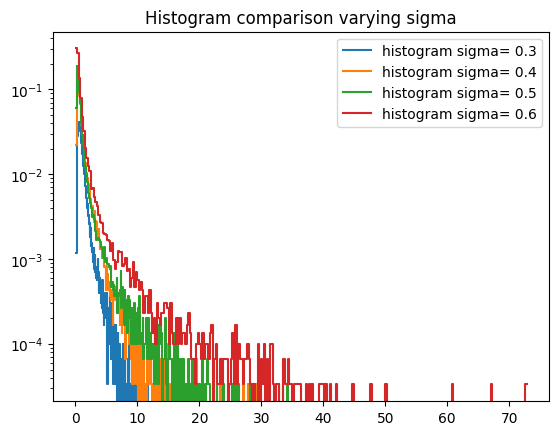

In [11]:
title = 'Histogram comparison varying sigma'
fplt.plot_histograms(grid, params, nbins=300, sigma=sigma, mu=mu, delta=delta, variation='sigma', on_run=False, title=title);

### Varying $\delta_t$

In __Milstein approximation__ to obtain the true solution $X$ we try to solve the SDE on some interval of time $[0, T]$. 
Then we partition the interval $[0,T]$ into $N$ __equal subintervals of width__ $\delta_t >0$. 

Not having any information about the expected values of this parameter, we explored different values of $\delta_t$. We noticed some abnormal results when generating dataset with values too far away from the optimal supposed value, obtained experimentally, of $0.2$. The following plot shows that the best values of this parameter, in our opinion, should be the ones closer to $0.2$, which produce light curves more similar to the ones presented by Tavecchio et al. [\[1\]](https://arxiv.org/pdf/2004.09149.pdf) in their paper. 

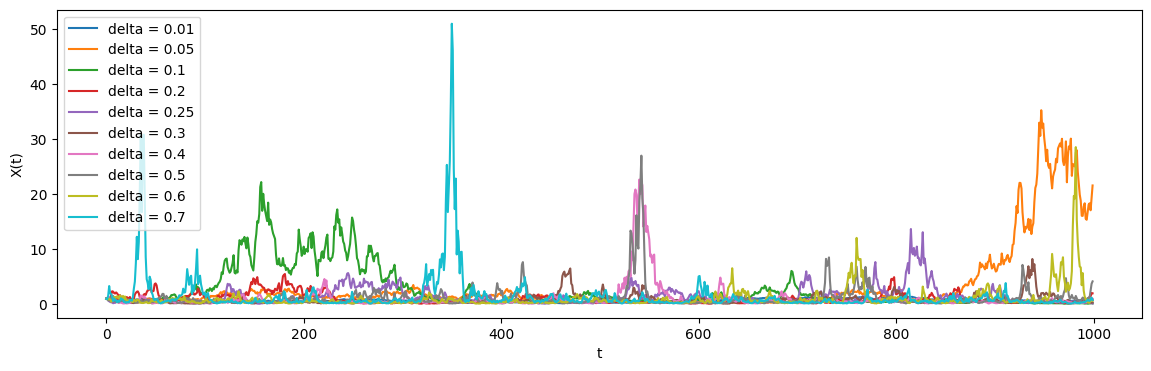

In [12]:
run, mu, sigma, theta = 0, 1, 0.5, 0.1
fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, 
                          variation='delta')

## Data labelling

Anomaly detection has been performed in order to obtain labeled samples from the time series data, being flares considered as anomalies in the normal behaviour of the star.

An handcrafted definition of flares has been adopted not having any official feedback from INAF

### Physics based method

Here we show a labelling method handcrafted and deterministic which is aimed to produce a threshold for each configuration of parameter independently from the run index.

* Since $\mu$ _identifies the equilibrium point_ where more or less the light curve must be circumvented. 
* Assuming to remove noise, the behaviour of the curve should be monotone increasing until it reaches a _horizontal asymptote_ on $\mu$. 
* Thus we can also assume that if on average the function lies on $\mu$ and a small percentage of noise is added to the curve, then to deduce the threshold we must add a small estimate of the noise at $\mu$. 
    * In particular, knowing that $\sigma$ is the _coefficient of the stochastic component_ (noise), which in turn is calculated as a function of the previous value of $X_{t-1}$ we have:
    $$\mu + \alpha(\sigma \cdot \mu)$$
with $\sigma$ coefficient of stochastic term and $\alpha$ an user defined parameter.


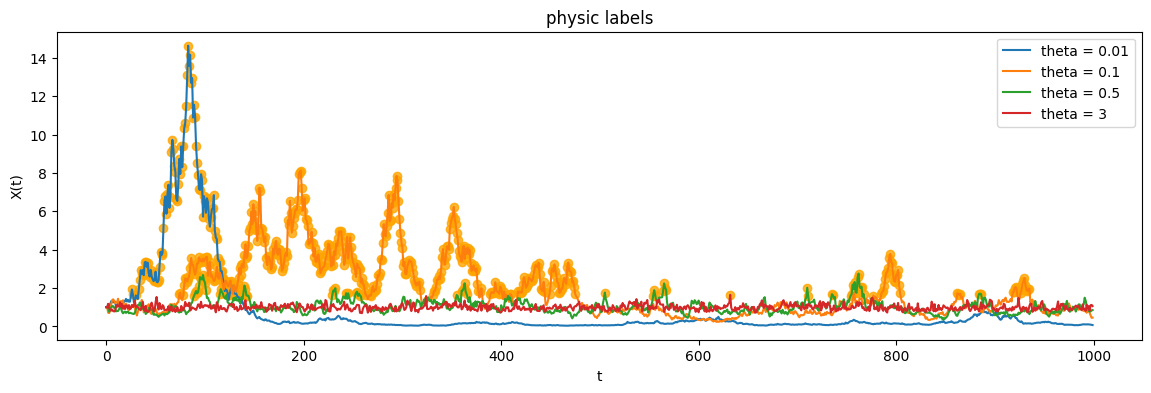

In [13]:
physic_labels = get_labels_physic(grid, params, alpha=2, override=override, folder=inspection_data_folder)
run, mu, sigma, theta, delta = 1, 1, 0.3, 0.1, 0.2
fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=2, variation='theta', labels=physic_labels, title='physic labels')

### KDE

Here we estimate the threshold following the KDE anomaly detection approach

We loop over all the configurations of parameters and we computed the KDE for each run of that configuration, taking the 0.99 quantile of the resulting scores as threshold. The final threshold for a given parameters combination is obtained as mean of all the threshold of that configuration.
At the end the predictions are obtained as thresholding the signals of each run of that combo of parameters.

Finally we drop all predictions which lower than the $\mu$, which we recall it being the equilibrium point, in order to remove anomalies which we are sure they are not flares.

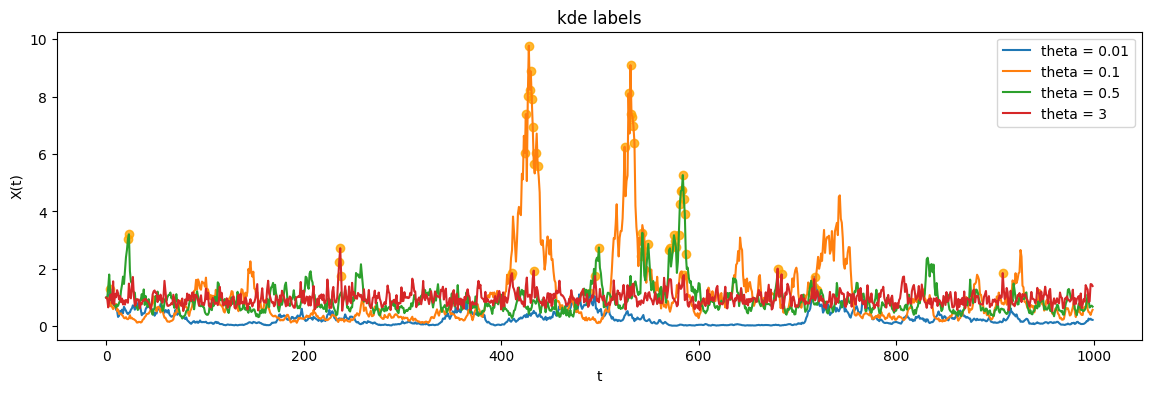

In [14]:
# this cell takes a lot of time
kde_labels = get_labels_KDE(grid, params, override=override, folder=inspection_data_folder)
run, mu, sigma, theta, delta = 3, 1, 0.5, 0.1, 0.2
fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, num_run=2,
                          variation='theta', labels=kde_labels, title='kde labels')

We can immediately notice a lower amount of labels in this second labelling method, which seems to be more selective in labelling

### Quantile method

Finally, we tried another quantile-based labelling method. In particular, we decided to categorise as flares all those values occupying the 0.8 percentile for each parameter configuration, normalising the values of the time series.

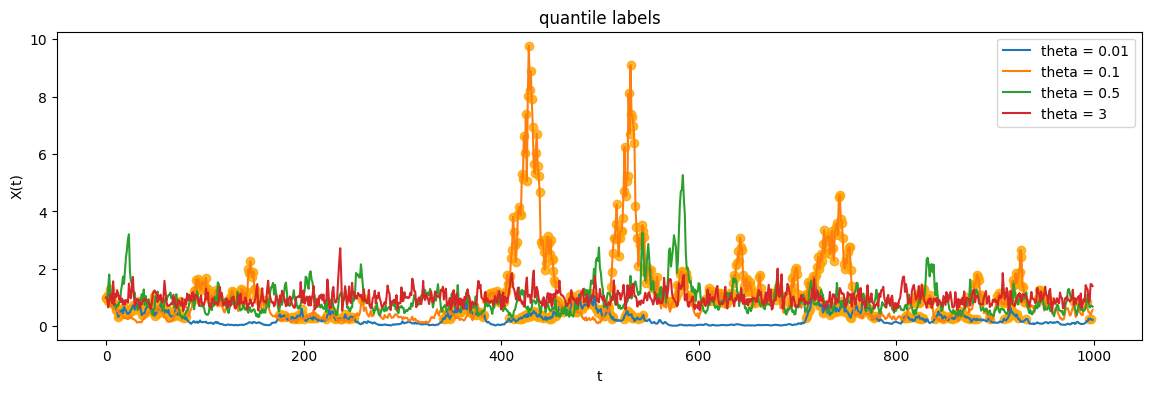

In [15]:
quantile_labels = get_labels_quantile(grid, params, percentile = 0.7, override=override, folder=inspection_data_folder)
run, mu, sigma, theta, delta = 3, 1, 0.5, 0.5, 0.2
fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta,num_run=2,
                          variation='theta', labels=quantile_labels, title='quantile labels')

### Best method

To sum up:
* The physic method is a deterministic and fast method which can achieve good result in an easy way, conforming to what we think could be a flare, just looking at the plot.
* The KDE still remains a good alternative, but it seems to returns a very low number of positive labels, detecting a small number of flares. 
    * maybe due to the absence of a cost model, but further imrovements can be still attempted
* The quantile method was disappointing, as the results produced more labels than expected in some cases than a visual analysis and fewer than expected in others. 
    * perhaps again a cost model or some quantile tuning would have helped this approach  

After a carefull examination of the anomaly detection methods that have been implemented, the simplest yet the most effective one has been selected. Namely the pyhsics based method.

Here the performance of this method with a random run of the "best" set of parameters is shown

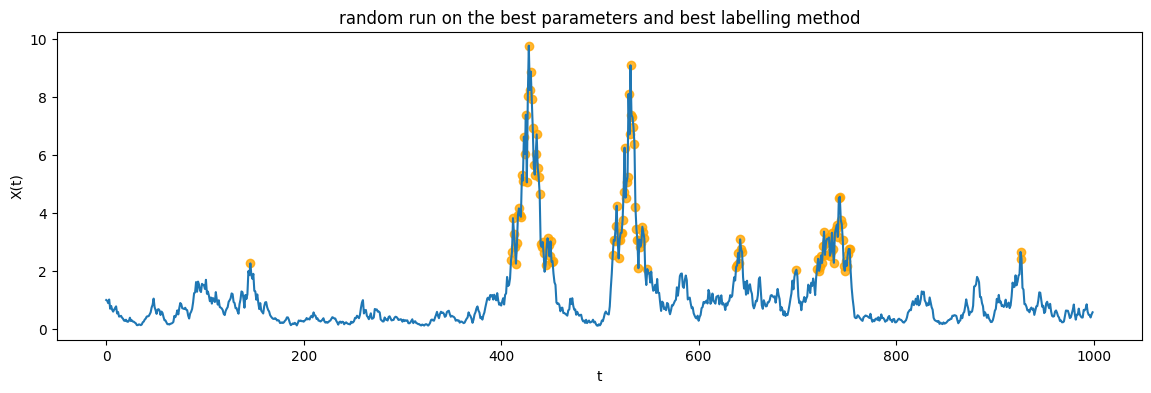

In [16]:
run = 3
labels_best = physic_labels
bindexes = data_loader.get_indexes(s=0.5, t=0.1, d=0.2, m=1)
X_best = grid[run, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]
best_labels = labels_best[run, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]
fplt.plot_serie(X_best, labels=best_labels, title='random run on the best parameters and best labelling method')

# Bibliography
\[1\] _On the distribution of fluxes of gamma-ray blazars: hints for a stochastic process?_, Tavecchio et al., [https://arxiv.org/pdf/2004.09149.pdf](https://arxiv.org/pdf/2004.09149.pdf)
<!-- cite with: [\[1\]](https://arxiv.org/pdf/2004.09149.pdf)  -->
\[2\] _Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline_, Wang et al., [https://arxiv.org/abs/1611.06455](https://arxiv.org/abs/1611.06455)
<!-- cite with: [\[2\]](https://arxiv.org/abs/1611.06455)  -->
\[3\] _Solar Flare Prediction Based on the Fusion of Multiple Deep-learning Models_, Tang et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)
<!-- cite with: [\[3\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac249e/meta)  -->
\[4\] _Predicting Solar Energetic Particles Using SDO/HMI Vector Magnetic Data Products and a Bidirectional LSTM Network_, Abduallah et al., [https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta)
<!-- cite with: [\[4\]](https://iopscience.iop.org/article/10.3847/1538-4365/ac5f56/meta) -->